In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

#### Problem Statement
Build a machine learning model to classify Reddit posts from r/technology and r/gadgets into emerging technology categories (e.g., AI, 5G, blockchain, electric vehicles) based on post titles. The goal is to automatically label posts with the technology they are discussing and analyze the distribution of posts across these categories to identify trends.
#### Evaluation Criteria
Success will be measured by the model’s classification accuracy, aiming for at least 85% accuracy in identifying the correct technology trend. The model will be evaluated using precision, recall, and F1 score. Additionally, we’ll track the number of posts per category to determine which technology trends are most discussed.
#### Stake Holders
The project is relevant for companies, investors, and tech enthusiasts who want to understand which emerging technologies are being talked about the most and are likely to gain traction. It helps in making data-driven decisions about innovation trends and tech investments.


### Load Dataset

In [16]:
data = pd.read_csv('./data/reddit_posts.csv')
data.head()

,post_id,title,content,timestamp,subreddit,category,comments
0,1fxjdc0,Pangolin-inspired robot poops tree seeds into ...,NaN,2024-10-06 15:41:34,gadgets,new,Didn’t Randy Marsh fuck a Pangolin after Micke...
1,1fxbi84,60TB hard drives arriving in 2028 according to...,NaN,2024-10-06 07:58:26,gadgets,new,Gotta get ready for that next Call of Duty | F...
2,1fwrybc,Intel says its Raptor Lake crashing chip night...,NaN,2024-10-05 14:43:29,gadgets,new,Now release a tool to tell me if my 14700K is ...
3,1fwjx9e,"Leak claims RTX 5090 has 600W TGP, RTX 5080 hi...",NaN,2024-10-05 06:10:55,gadgets,new,Why is this week old rumor being spammed? Any...
4,1fwh2bu,Insecure Deebot robot vacuums collect photos a...,NaN,2024-10-05 03:09:58,gadgets,new,Maybe they need some a good pep talk to boost ...


In [20]:
data.shape

(11890, 7)

In [391]:
data.isna().sum()

post_id          0
title            0
content      11789
timestamp        0
subreddit        0
category         0
comments      1990
dtype: int64

In [393]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11890 entries, 0 to 11889
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   post_id    11890 non-null  object
 1   title      11890 non-null  object
 2   content    101 non-null    object
 3   timestamp  11890 non-null  object
 4   subreddit  11890 non-null  object
 5   category   11890 non-null  object
 6   comments   9900 non-null   object
dtypes: object(7)
memory usage: 650.4+ KB


In [395]:
data['subreddit'].value_counts()

subreddit
technology    6901
gadgets       4989
Name: count, dtype: int64

Text(0, 0.5, 'Frequency')

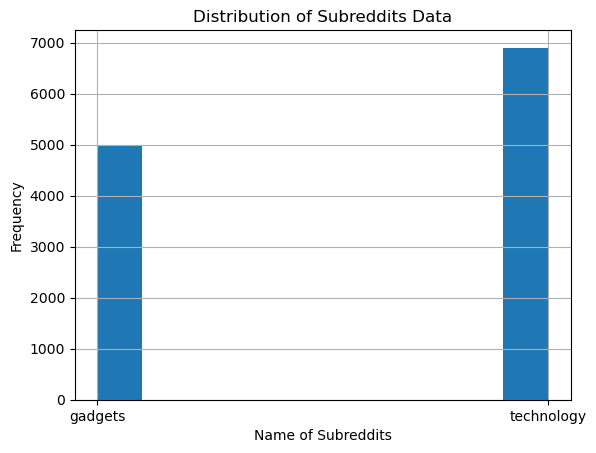

In [397]:
data['subreddit'].hist()
plt.title('Distribution of Subreddits Data')
plt.xlabel('Name of Subreddits')
plt.ylabel('Frequency')

In [401]:
data['post_id'].nunique()


4951

In [403]:
data1 = data.drop_duplicates(subset=['post_id'])

In [417]:
data1['subreddit'].value_counts()

subreddit
gadgets       2586
technology    2365
Name: count, dtype: int64

In [405]:
data1.head()

,post_id,title,content,timestamp,subreddit,category,comments
0,1fxjdc0,Pangolin-inspired robot poops tree seeds into ...,NaN,2024-10-06 15:41:34,gadgets,new,Didn’t Randy Marsh fuck a Pangolin after Micke...
1,1fxbi84,60TB hard drives arriving in 2028 according to...,NaN,2024-10-06 07:58:26,gadgets,new,Gotta get ready for that next Call of Duty | F...
2,1fwrybc,Intel says its Raptor Lake crashing chip night...,NaN,2024-10-05 14:43:29,gadgets,new,Now release a tool to tell me if my 14700K is ...
3,1fwjx9e,"Leak claims RTX 5090 has 600W TGP, RTX 5080 hi...",NaN,2024-10-05 06:10:55,gadgets,new,Why is this week old rumor being spammed? Any...
4,1fwh2bu,Insecure Deebot robot vacuums collect photos a...,NaN,2024-10-05 03:09:58,gadgets,new,Maybe they need some a good pep talk to boost ...


#### Define Emerging Technology Trends

In [407]:
#these categories will serve as labels for titles
tech_keywords = {
'AI': ['artificial intelligence', 'machine learning', 'deep learning', 'neural network', 'ai', 'natural language processing', 'robotics', 'automation', 'artificial neural network', 'data science', 'predictive analytics'],
    
'Blockchain': ['blockchain', 'cryptocurrency', 'bitcoin', 'ethereum', 'smart contracts', 'decentralized', 'defi', 'nft', 'web3'],
    
'5G': ['5g', 'next-gen network', 'fifth generation', 'latency', 'mmwave', 'telecom', 'network infrastructure'],
    
'Electric Vehicles': ['electric vehicle', 'ev', 'tesla', 'battery', 'autonomous driving', 'self-driving', 'renewable energy','e-bike','electric bike'],
    
'Wearable Tech': ['wearables', 'smartwatch', 'fitness tracker', 'apple watch', 'fitbit', 'ar glasses', 'vr headset', 'virtual reality','headphone', 'earbuds'],
    
'Quantum Computing': ['quantum computing', 'qubits', 'quantum supremacy', 'superposition', 'entanglement'],
    
'Cybersecurity': ['cybersecurity', 'data breach', 'ransomware', 'malware', 'encryption', 'vulnerability', 'threat detection'],
    
'IoT': ['iot', 'connected devices', 'smart devices', 'sensor network', 'smart home', 'industrial iot'],
    
'Cloud Computing': ['cloud', 'aws', 'azure', 'google cloud', 'serverless', 'virtualization', 'cloud storage'],
    
'AR/VR': ['augmented reality', 'virtual reality', 'ar', 'vr', 'immersive experience', 'headset', 'oculus', 'vision pro', 'meta quest', 'htc vive', 'playstation vr', 'valve index', 
 'immersive experience', 'virtual reality', 'augmented reality', 'mixed reality', 'spatial computing','magic leap', 'hololens', 'vr headset', 'ar glasses'
],
    
'Chip Technologies': ['chip', 'semiconductor', 'processor', 'microchip', 'integrated circuit', 'intel', 'amd', 'nvidia', 'arm', 'tsmc', 'qualcomm', 'fabless', 'silicon', 'wafer', 'transistor', 'chipset', 'cpu', 'gpu', 'fpga', 'nanometer technology', '3nm', '5nm', '7nm', 'foundry'],

'Smart Devices' : ['smartphone', 'tablet', 'smart speaker', 'smart display', 'smart home', 'smart thermostat', 'smart light', 'smart lock', 'smart camera', 'voice assistant', 'alexa', 'google assistant', 'siri', 'nest', 'ring', 'smart refrigerator', 'smart tv', 'home automation', 'connected home', 'smart device','iphone', 'samsung', 'galaxy', 'pixel', 'oneplus', 'huawei', 'xiaomi','apple','google','alexa'
],

'Robotics' :[
    'robot', 'robotic', 'autonomous machines', 'drone', 'mechanical system', 
    'automation', 'industrial robot', 'humanoid', 'self-driving', 'drone technology','drone'
],
'Gaming Consoles':[
    'playstation', 'xbox', 'nintendo switch', 'steam deck', 'rog ally', 
    'gaming console', 'handheld console', 'game controller', 'vr gaming', 'console gaming','game','retro gaming'

]

}

In [409]:
import spacy
import re

# Load spacy model for lemmatization
nlp = spacy.load("en_core_web_md")

def label_data(text):
    # Lemmatize the input text
    doc = nlp(text.lower())
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    
    # Loop through tech keywords and apply partial matching
    for tech, keywords in tech_keywords.items():
        for keyword in keywords:
            # Use regex partial matching, allowing variations
            pattern = f'{re.escape(keyword)}'
            if re.search(pattern, lemmatized_text):
                return tech
    return 'Other'


In [411]:
data1.head()

,post_id,title,content,timestamp,subreddit,category,comments
0,1fxjdc0,Pangolin-inspired robot poops tree seeds into ...,NaN,2024-10-06 15:41:34,gadgets,new,Didn’t Randy Marsh fuck a Pangolin after Micke...
1,1fxbi84,60TB hard drives arriving in 2028 according to...,NaN,2024-10-06 07:58:26,gadgets,new,Gotta get ready for that next Call of Duty | F...
2,1fwrybc,Intel says its Raptor Lake crashing chip night...,NaN,2024-10-05 14:43:29,gadgets,new,Now release a tool to tell me if my 14700K is ...
3,1fwjx9e,"Leak claims RTX 5090 has 600W TGP, RTX 5080 hi...",NaN,2024-10-05 06:10:55,gadgets,new,Why is this week old rumor being spammed? Any...
4,1fwh2bu,Insecure Deebot robot vacuums collect photos a...,NaN,2024-10-05 03:09:58,gadgets,new,Maybe they need some a good pep talk to boost ...


In [413]:
data1['label'] = data1['title'].apply(label_data)

/var/folders/cm/33j13stn00579z5k7swhdxcw0000gp/T/ipykernel_58835/3308407551.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['label'] = data1['title'].apply(label_data)


In [414]:
data1.shape

(4951, 8)

In [415]:
data1['label'].value_counts()

label
AI                   1265
AR/VR                1178
Other                1065
Electric Vehicles     678
Smart Devices         388
Chip Technologies     103
Wearable Tech          90
Robotics               61
Gaming Consoles        61
Cloud Computing        25
Cybersecurity          15
5G                      9
IoT                     7
Blockchain              5
Quantum Computing       1
Name: count, dtype: int64

In [351]:
# Filter the DataFrame to get only the posts labeled as 'Other'
other_posts = data1[data1['label'] == 'Other']
other_posts

,title,content,timestamp,subreddit,category,comments,label
1,Collapse of national security elites’ cyber fi...,NaN,2024-10-06 04:46:03,technology,new,“The future was once dazzling for IronNet.\n\n...,Other
2,Teens already on social media could be exempt ...,NaN,2024-10-06 03:55:20,technology,new,NaN,Other
12,"Amazon Layoffs: Tech Firm To Cut 14,000 Manage...",NaN,2024-10-05 18:01:52,technology,new,"Man, Amazon’s approach is going to kill it. No...",Other
14,X reportedly paid its Brazil fines to the wron...,NaN,2024-10-05 17:34:13,technology,new,"They really need better attorneys, they even m...",Other
22,Facebook launches a Gen Z-focused redesign,NaN,2024-10-05 13:43:11,technology,new,Facebook is 90% AI generated content being lik...,Other
...,...,...,...,...,...,...,...
3668,Cybertruck Owner’s Manual Says Its Hitch Is On...,NaN,2024-09-20 04:18:53,technology,new,It’s been posted a bunch of times elsewhere th...,Other
3669,Microsoft releases a new Windows app called Wi...,NaN,2024-09-20 03:53:20,technology,new,I often wonder which idiot at microsoft is res...,Other
3670,Social media and online video firms are conduc...,NaN,2024-09-20 03:43:01,technology,new,which might have been a shocking headline in ...,Other
3679,FTC Says Social Media Platforms Engage in 'Vas...,NaN,2024-09-19 22:50:17,technology,new,"""The FTC issued a warning letter back in late ...",Other


### Labeling Data  